In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:2px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:10pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:11pt;padding:4px;}
table.dataframe{font-size:10px;}
</style>
"""))

Íµ≠Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): Ï§ëÍµ≠
Î™©Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): Í¥ÄÍ¥ë
‚úÖ XGBoost MAE: 57352.21, RMSE: 90082.75
       Ïã§Ï†úÍ∞í            ÏòàÏ∏°Í∞í       Ïó∞Ïõî
0     1031    5076.510742  2021-07
1     1011    5076.510742  2021-08
2     1264    2935.910645  2021-09
3     1366    2935.910645  2021-10
4     1700    2935.910645  2021-11
5     2151    2935.910645  2021-12
6     1641    3516.418701  2022-01
7     1194    3516.418701  2022-02
8     1480    5076.510742  2022-03
9     1857    5076.510742  2022-04
10    1703    5076.510742  2022-05
11    3234    5076.510742  2022-06
12    5960     576.804138  2022-07
13    5986     576.804138  2022-08
14    8107   -1563.795410  2022-09
15    9311   -1563.795410  2022-10
16   10331   -1563.795410  2022-11
17   15719   -1563.795410  2022-12
18   12343    -983.287048  2023-01
19    8813    -983.287048  2023-02
20   29883     576.804138  2023-03
21   75815    3804.595215  2023-04
22   87807   36677.585938  2023-05
23  128482   62151.335

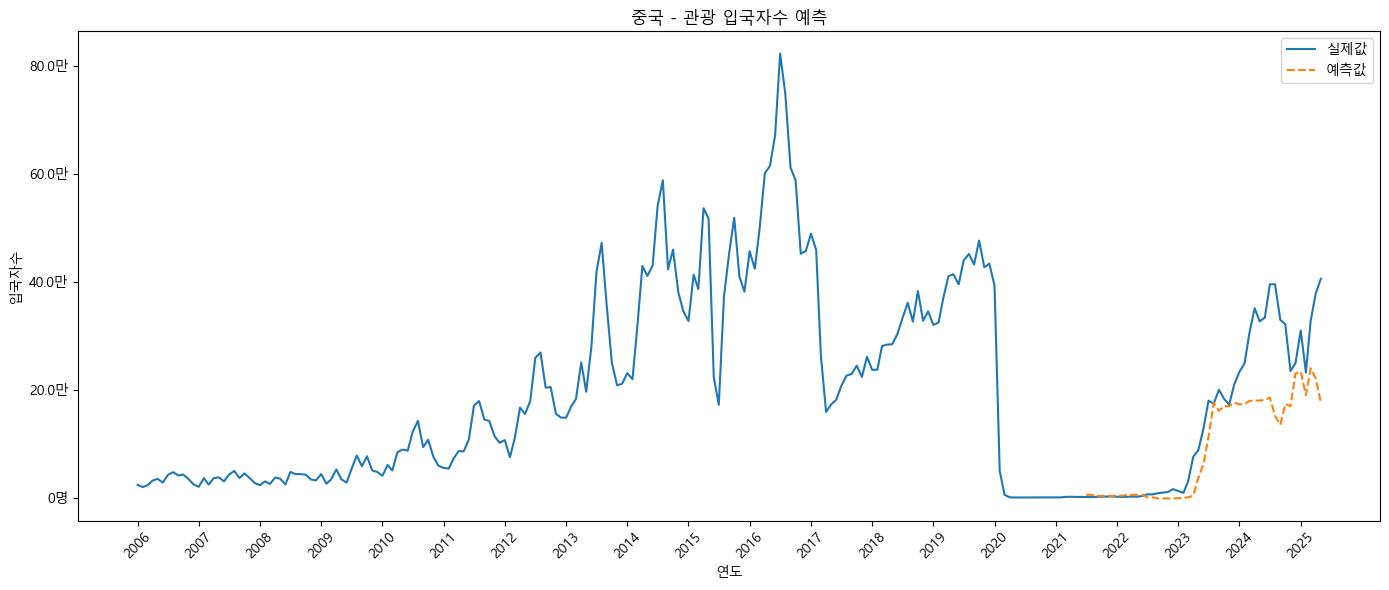

12:51:59 - cmdstanpy - INFO - Chain [1] start processing
12:51:59 - cmdstanpy - INFO - Chain [1] done processing


            ds           yhat    yhat_lower     yhat_upper
240 2025-12-31  106088.188996 -60240.034495  273890.132482
241 2026-01-31   72399.898091 -96304.796863  241710.367730
242 2026-02-28   75549.158439 -95829.289650  243599.049674
243 2026-03-31  121795.895554 -54900.041779  286518.306122
244 2026-04-30  122919.507678 -46088.327246  306101.541341


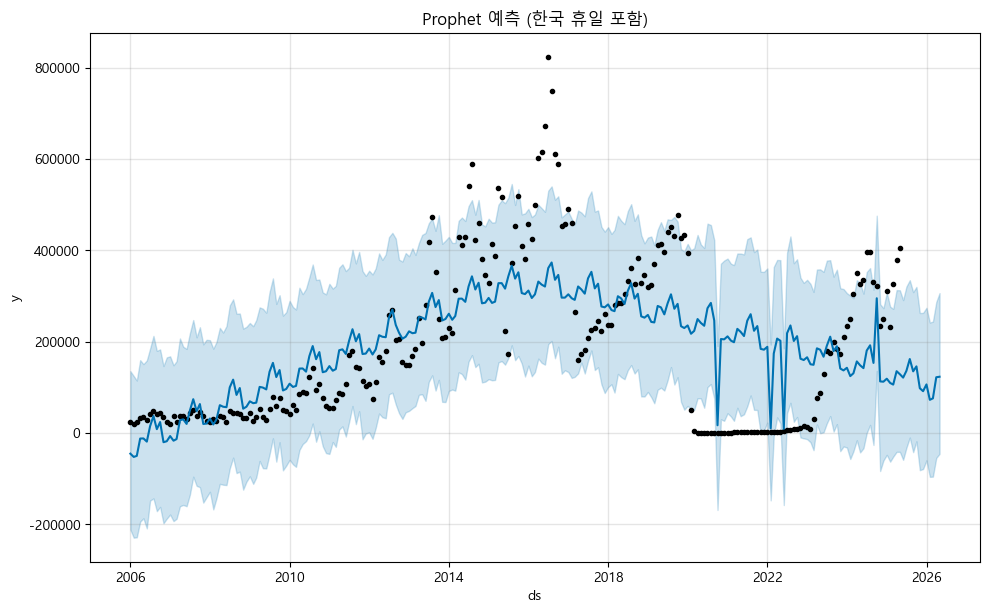

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ‚úÖ ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 1Ô∏è‚É£ CSV Î°úÎìú
df = pd.read_csv('../../jin/data/processed/Ïô∏Íµ≠Ïù∏ÏûÖÍµ≠Ïûê_Ï†ÑÏ≤òÎ¶¨ÏôÑÎ£å_Îî•Îü¨ÎãùÏö©.csv', encoding='utf-8')

# 2Ô∏è‚É£ ÏÇ¨Ïö©Ïûê ÏûÖÎ†• Ìï®Ïàò
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"‚ùå ÏùºÏπòÌïòÎäî {column_name} ÏóÜÏùå. Îã§Ïãú ÏûÖÎ†•.")

# Íµ≠Í∞Ä ÏûÖÎ†•
country = get_valid_input('Íµ≠Ï†Å')
# Î™©Ï†Å ÏûÖÎ†•
purpose = get_valid_input('Î™©Ï†Å', allow_blank=True)

# 3Ô∏è‚É£ ÌïÑÌÑ∞ÎßÅ
df = df[df['Íµ≠Ï†Å'] == country]
if purpose:
    df = df[df['Î™©Ï†Å'] == purpose]

# ‚úÖ ÌïÑÌÑ∞ÎßÅ ÏòàÏô∏Ï≤òÎ¶¨
if df.empty:
    raise ValueError("‚ö†Ô∏è Ï°∞Í±¥Ïóê ÎßûÎäî Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")

# 4Ô∏è‚É£ Ïù∏ÏΩîÎî©
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['Í≥ÑÏ†à'] = le_season.fit_transform(df['Í≥ÑÏ†à'])
df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = le_corona.fit_transform(df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'])
df['Ïó∞Ïõî'] = df['Ïó∞ÎèÑ'].astype(str) + '-' + df['Ïõî'].astype(str).str.zfill(2)

# 5Ô∏è‚É£ ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ
df['lag_1'] = df['ÏûÖÍµ≠ÏûêÏàò'].shift(1)
df['lag_3'] = df['ÏûÖÍµ≠ÏûêÏàò'].shift(3)
df['lag_12'] = df['ÏûÖÍµ≠ÏûêÏàò'].shift(12)
df['ÏûÖÍµ≠ÏûêÏàò_cumsum'] = df['ÏûÖÍµ≠ÏûêÏàò'].cumsum()
df = df.dropna()

# 6Ô∏è‚É£ Feature ÏÑ†ÌÉù
features = ['Ïó∞ÎèÑ', 'Ïõî', 'Î∂ÑÍ∏∞', 'Í≥ÑÏ†à', 'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ', 'lag_1', 'lag_3', 'lag_12', 'ÏûÖÍµ≠ÏûêÏàò_cumsum']
X = df[features]
y = df['ÏûÖÍµ≠ÏûêÏàò']
ym = df['Ïó∞Ïõî'].reset_index(drop=True)

# 7Ô∏è‚É£ Ï†ïÍ∑úÌôî
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 8Ô∏è‚É£ Î∂ÑÌï†
X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
    X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
)

# 9Ô∏è‚É£ XGBoost
params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
grid = GridSearchCV(XGBRegressor(), params, cv=2)
grid.fit(X_train, y_train)
xgb_model = grid.best_estimator_

# üîü ÏòàÏ∏°
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"‚úÖ XGBoost MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# üîü-2 Í≤∞Í≥º ÌÖåÏù¥Î∏î
results = pd.DataFrame({
    'Ïã§Ï†úÍ∞í': y_test.values,
    'ÏòàÏ∏°Í∞í': y_pred,
    'Ïó∞Ïõî': ym_test.values
})
print(results)

# üîü-3 ÏÑ†Í∑∏ÎûòÌîÑ
purpose_list = [purpose] if purpose else df['Î™©Ï†Å'].unique()

for p in purpose_list:
    temp = df[df['Î™©Ï†Å'] == p] if not purpose else df
    temp_sorted = temp.sort_values(['Ïó∞ÎèÑ', 'Ïõî']).copy()

    # ‚úÖ Ïó∞Ïõî ‚Üí date Ïª¨Îüº Ï∂îÍ∞Ä
    temp_sorted['date'] = pd.to_datetime(temp_sorted['Ïó∞Ïõî'])
    results['date'] = pd.to_datetime(results['Ïó∞Ïõî'])

    fig, ax = plt.subplots(figsize=(14, 6))

    # ‚úÖ XÏ∂ï: Ïó∞ÎèÑÎßå Tick
    year_ticks = temp_sorted[temp_sorted['date'].dt.month == 1]['date'].drop_duplicates()
    ax.set_xticks(year_ticks)
    ax.set_xticklabels([d.strftime('%Y') for d in year_ticks], rotation=45)

    # ‚úÖ ÏÑ†Í∑∏ÎûòÌîÑ
    ax.plot(temp_sorted['date'], temp_sorted['ÏûÖÍµ≠ÏûêÏàò'], label='Ïã§Ï†úÍ∞í')
    ax.plot(results['date'], results['ÏòàÏ∏°Í∞í'], linestyle='--', label='ÏòàÏ∏°Í∞í')

    # ‚úÖ YÏ∂ï: Îßå Îã®ÏúÑ
    def to_unit(x, pos):
        if x >= 10000:
            return f'{x/10000:.1f}Îßå'
        else:
            return f'{int(x)}Î™Ö'

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))

    ax.set_title(f"{country} - {p if p else 'Ï†ÑÏ≤¥ Î™©Ï†Å'} ÏûÖÍµ≠ÏûêÏàò ÏòàÏ∏°")
    ax.set_xlabel('Ïó∞ÎèÑ')
    ax.set_ylabel('ÏûÖÍµ≠ÏûêÏàò')
    ax.legend()
    plt.tight_layout()
    plt.show()

# üîü-4 Prophet
prophet_df = df[['Ïó∞Ïõî', 'ÏûÖÍµ≠ÏûêÏàò']].copy()
prophet_df.rename(columns={'Ïó∞Ïõî': 'ds', 'ÏûÖÍµ≠ÏûêÏàò': 'y'}, inplace=True)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

m = Prophet()
m.add_country_holidays(country_name='KR')
m.fit(prophet_df)

future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

fig = m.plot(forecast)
plt.title('Prophet ÏòàÏ∏° (ÌïúÍµ≠ Ìú¥Ïùº Ìè¨Ìï®)')
plt.show()


Íµ≠Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ÎØ∏Íµ≠
Î™©Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): 
‚úÖ XGBoost MAE: 483.76, RMSE: 566.57
      Ïã§Ï†úÍ∞í          ÏòàÏ∏°Í∞í       Ïó∞Ïõî
0      95   499.449371  2009-11
1      73   499.449371  2009-12
2     135   440.538696  2010-01
3     391   487.143494  2010-02
4      61   512.032776  2010-03
..    ...          ...      ...
182   303   706.308228  2025-01
183  1716   609.272888  2025-02
184   272  1674.285889  2025-03
185   139   609.818054  2025-04
186   743   940.989136  2025-05

[187 rows x 3 columns]


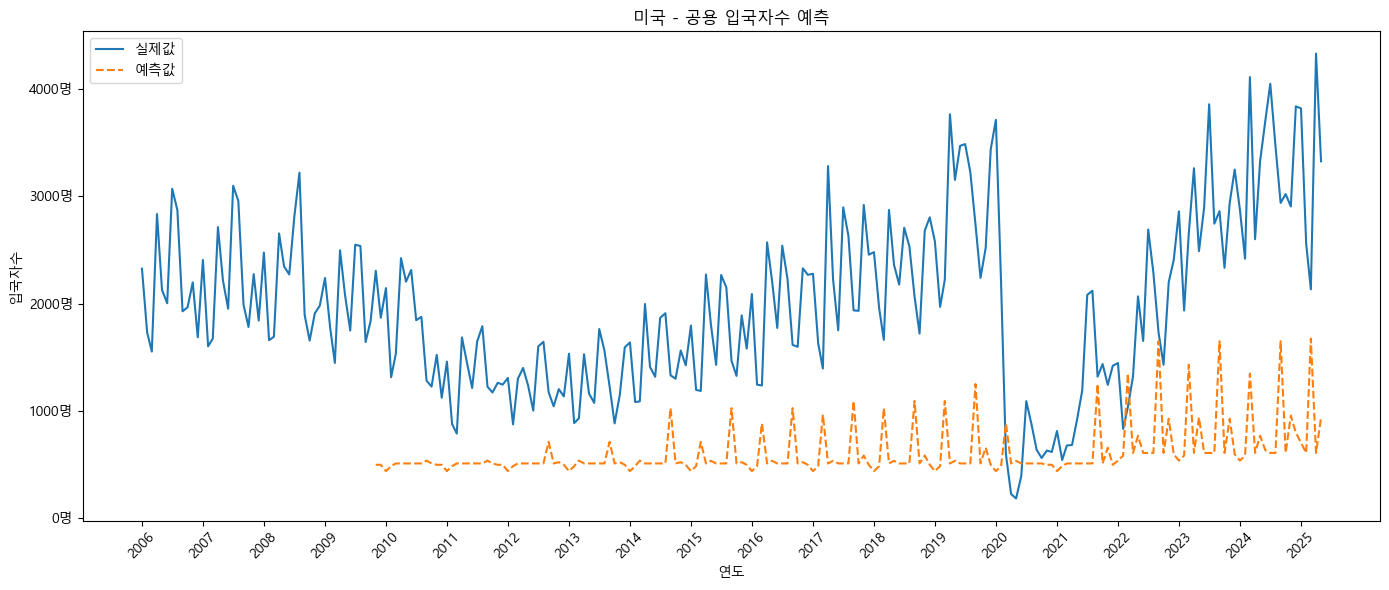

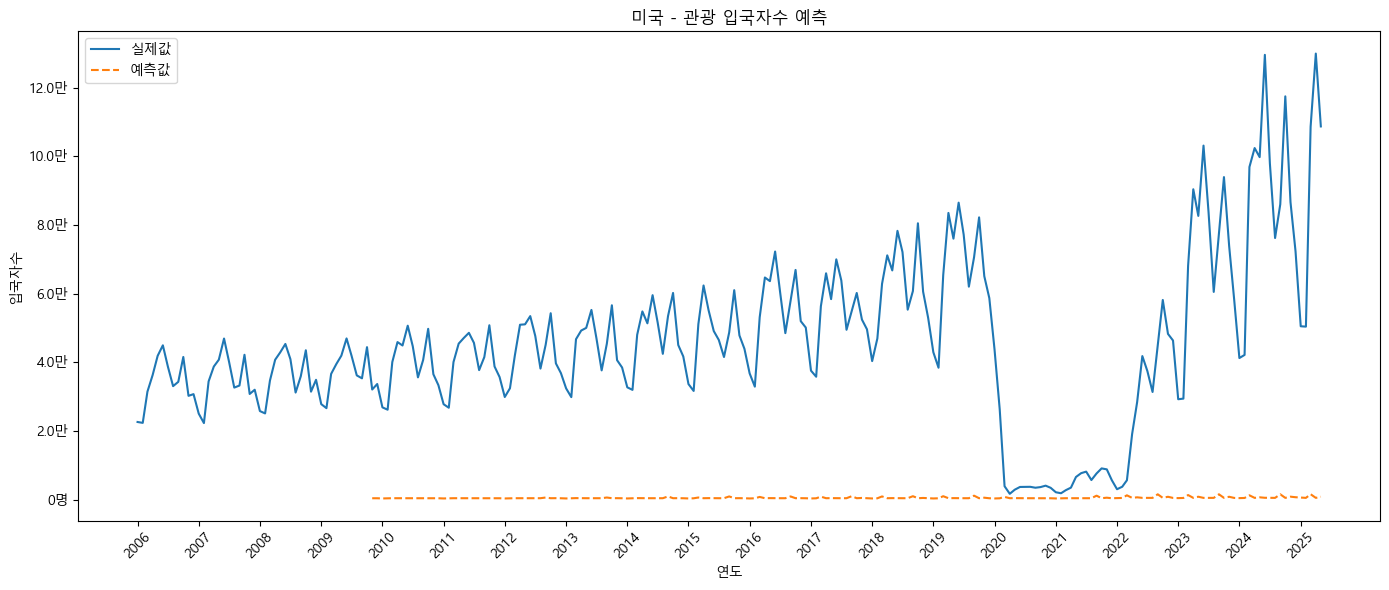

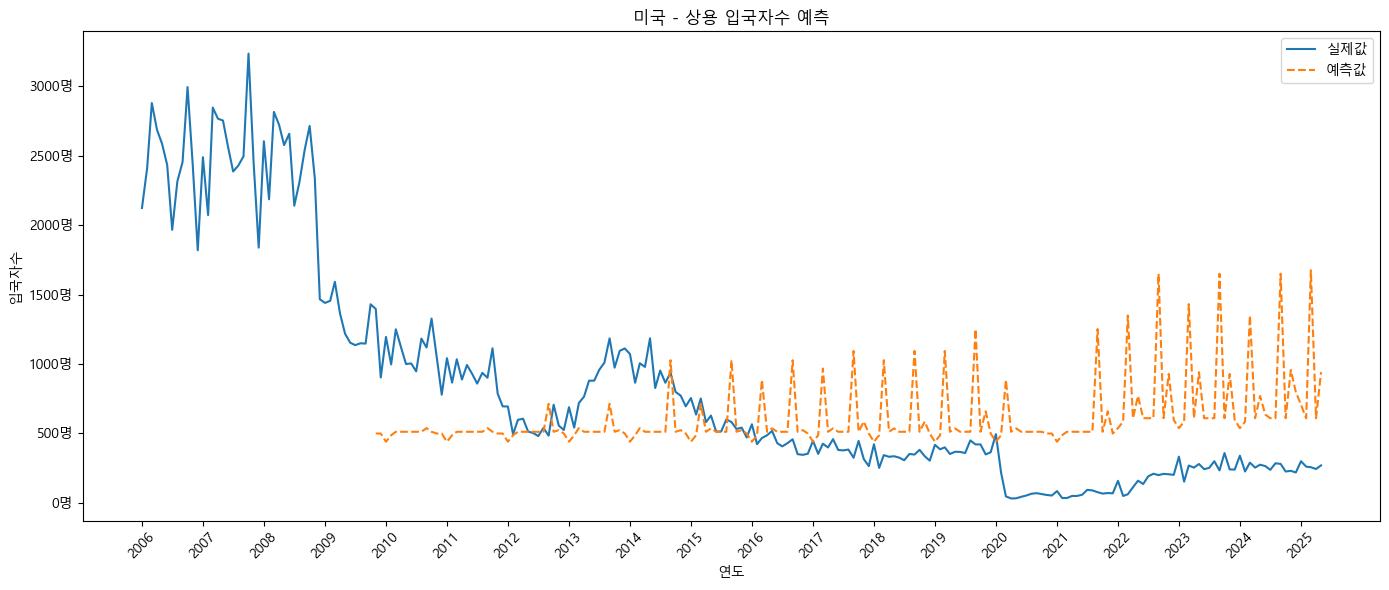

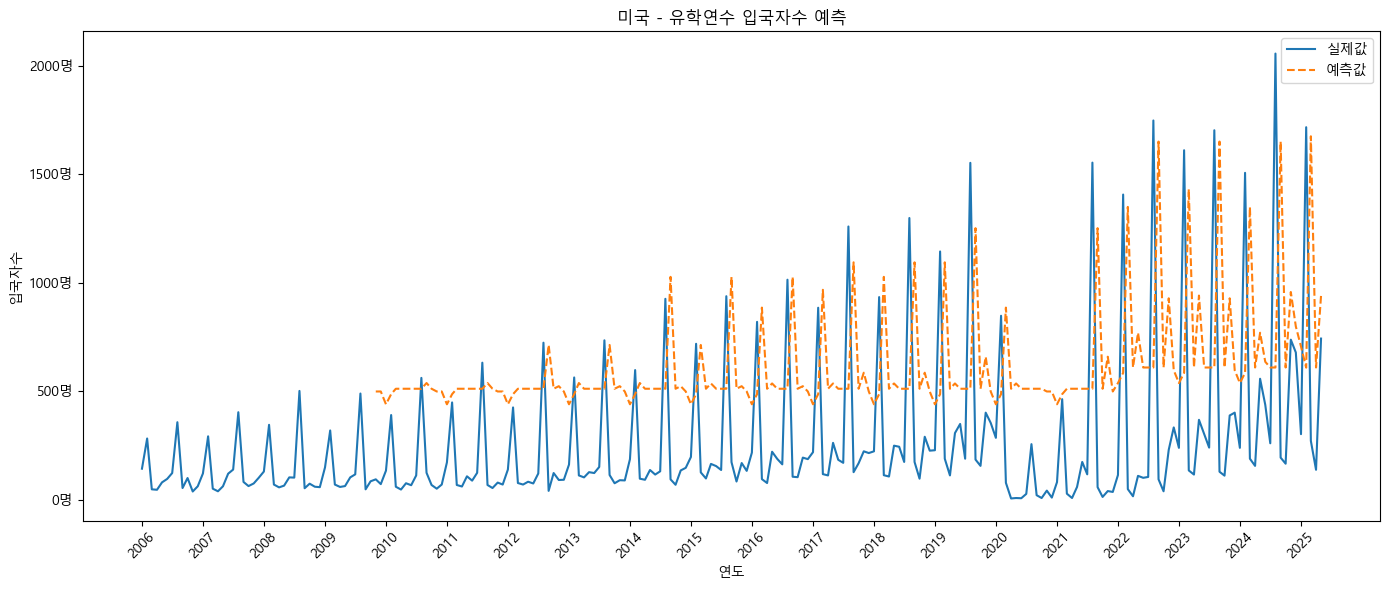

12:58:27 - cmdstanpy - INFO - Chain [1] start processing
12:58:27 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
233 2025-05-31  23815.743662  -6670.132958  50507.452648
234 2025-06-30  20215.987170  -6300.125660  48131.663498
235 2025-07-31  19020.932061  -7386.540613  48064.027116
236 2025-08-31  20634.515156  -9108.437212  48553.793077
237 2025-09-30  23016.626041  -4323.559899  51747.728999
238 2025-10-31  20420.893359  -7176.418840  47501.585370
239 2025-11-30  17564.840441 -10216.176451  46721.572953
240 2025-12-31  16792.702191 -10784.494623  44459.289337
241 2026-01-31  16147.368912 -12725.441424  43040.707852
242 2026-02-28  22185.916244  -6205.411445  50668.703239
243 2026-03-31  23684.595972  -4140.982534  51859.303862
244 2026-04-30  23020.431658  -5063.416482  50579.220633


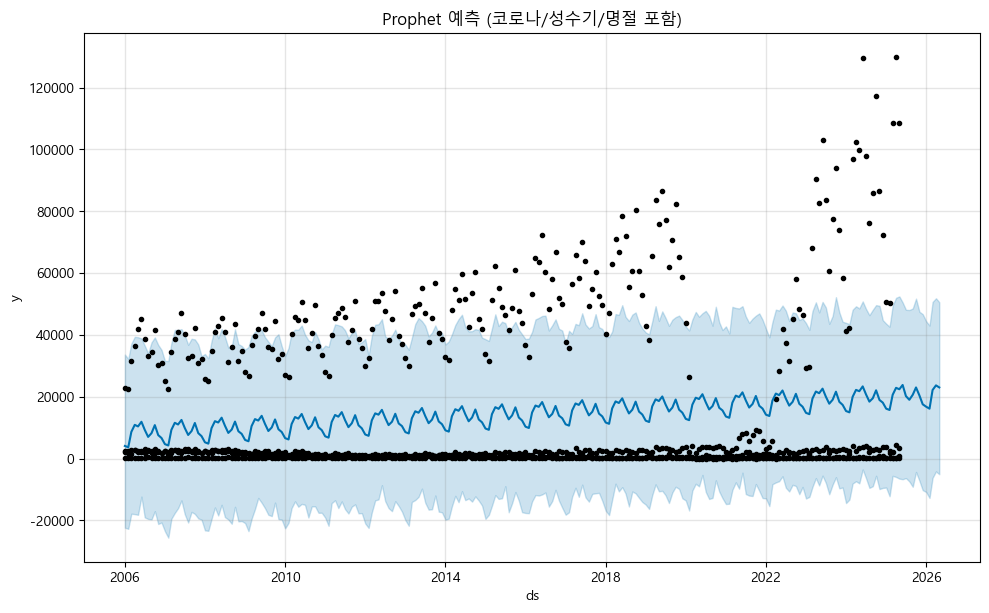

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ‚úÖ ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 1Ô∏è‚É£ CSV Î°úÎìú
df = pd.read_csv('../../jin/data/processed/Ïô∏Íµ≠Ïù∏ÏûÖÍµ≠Ïûê_Ï†ÑÏ≤òÎ¶¨ÏôÑÎ£å_Îî•Îü¨ÎãùÏö©.csv', encoding='utf-8')

# ‚úÖ ÏÇ¨Ïö©Ïûê ÏûÖÎ†• Ìï®Ïàò
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"‚ùå ÏùºÏπòÌïòÎäî {column_name} ÏóÜÏùå. Îã§Ïãú ÏûÖÎ†•.")

# ‚úÖ Íµ≠Í∞Ä & Î™©Ï†Å ÏûÖÎ†•
country = get_valid_input('Íµ≠Ï†Å')
purpose = get_valid_input('Î™©Ï†Å', allow_blank=True)

# ‚úÖ ÌïÑÌÑ∞ÎßÅ
df = df[df['Íµ≠Ï†Å'] == country]
if purpose:
    df = df[df['Î™©Ï†Å'] == purpose]
if df.empty:
    raise ValueError("‚ö†Ô∏è Ï°∞Í±¥Ïóê ÎßûÎäî Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")

# ‚úÖ Ïù∏ÏΩîÎî©
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['Í≥ÑÏ†à'] = le_season.fit_transform(df['Í≥ÑÏ†à'])
df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = le_corona.fit_transform(df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'])
df['Ïó∞Ïõî'] = df['Ïó∞ÎèÑ'].astype(str) + '-' + df['Ïõî'].astype(str).str.zfill(2)

# ‚úÖ ÌäπÏù¥Ï†ê Dummy Ï∂îÍ∞Ä
df['ÏÑ±ÏàòÍ∏∞'] = df['Ïõî'].apply(lambda x: 1 if x in [7, 8, 12] else 0)
df['Î™ÖÏ†à'] = df['Ïõî'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0)

# ‚úÖ ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ
df['lag_1'] = df['ÏûÖÍµ≠ÏûêÏàò'].shift(1)
df['lag_3'] = df['ÏûÖÍµ≠ÏûêÏàò'].shift(3)
df['lag_12'] = df['ÏûÖÍµ≠ÏûêÏàò'].shift(12)
df['ÏûÖÍµ≠ÏûêÏàò_cumsum'] = df['ÏûÖÍµ≠ÏûêÏàò'].cumsum()
df = df.dropna()

# ‚úÖ Feature ÏÑ†ÌÉù
features = [
    'Ïó∞ÎèÑ', 'Ïõî', 'Î∂ÑÍ∏∞', 'Í≥ÑÏ†à', 'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ', 'ÏÑ±ÏàòÍ∏∞', 'Î™ÖÏ†à',
    'lag_1', 'lag_3', 'lag_12', 'ÏûÖÍµ≠ÏûêÏàò_cumsum'
]
X = df[features]
y = df['ÏûÖÍµ≠ÏûêÏàò']
ym = df['Ïó∞Ïõî'].reset_index(drop=True)

# ‚úÖ Ï†ïÍ∑úÌôî
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
    X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
)

# ‚úÖ XGBoost
params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
grid = GridSearchCV(XGBRegressor(), params, cv=2)
grid.fit(X_train, y_train)
xgb_model = grid.best_estimator_

# ‚úÖ ÏòàÏ∏°
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"‚úÖ XGBoost MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# ‚úÖ Í≤∞Í≥º ÌÖåÏù¥Î∏î
results = pd.DataFrame({
    'Ïã§Ï†úÍ∞í': y_test.values,
    'ÏòàÏ∏°Í∞í': y_pred,
    'Ïó∞Ïõî': ym_test.values
})
print(results)

# ‚úÖ YÏ∂ï Formatter
def to_unit(x, pos):
    if x >= 10000:
        return f'{x/10000:.1f}Îßå'
    else:
        return f'{int(x)}Î™Ö'

# ‚úÖ XGBoost ÏÑ†Í∑∏ÎûòÌîÑ
purpose_list = [purpose] if purpose else df['Î™©Ï†Å'].unique()

for p in purpose_list:
    temp = df[df['Î™©Ï†Å'] == p] if not purpose else df
    temp_sorted = temp.sort_values(['Ïó∞ÎèÑ', 'Ïõî']).copy()
    temp_sorted['date'] = pd.to_datetime(temp_sorted['Ïó∞Ïõî'])
    results['date'] = pd.to_datetime(results['Ïó∞Ïõî'])

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(temp_sorted['date'], temp_sorted['ÏûÖÍµ≠ÏûêÏàò'], label='Ïã§Ï†úÍ∞í')
    ax.plot(results['date'], results['ÏòàÏ∏°Í∞í'], linestyle='--', label='ÏòàÏ∏°Í∞í')

    year_ticks = temp_sorted[temp_sorted['date'].dt.month == 1]['date'].drop_duplicates()
    ax.set_xticks(year_ticks)
    ax.set_xticklabels([d.strftime('%Y') for d in year_ticks], rotation=45)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))

    ax.set_title(f"{country} - {p if p else 'Ï†ÑÏ≤¥ Î™©Ï†Å'} ÏûÖÍµ≠ÏûêÏàò ÏòàÏ∏°")
    ax.set_xlabel('Ïó∞ÎèÑ')
    ax.set_ylabel('ÏûÖÍµ≠ÏûêÏàò')
    ax.legend()
    plt.tight_layout()
    plt.show()

# ‚úÖ Prophet (ÌäπÏù¥Ï†ê Ìè¨Ìï®)
prophet_df = df[['Ïó∞Ïõî', 'ÏûÖÍµ≠ÏûêÏàò', 'Ïõî', 'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ', 'ÏÑ±ÏàòÍ∏∞', 'Î™ÖÏ†à']].copy()
prophet_df.rename(columns={'Ïó∞Ïõî': 'ds', 'ÏûÖÍµ≠ÏûêÏàò': 'y'}, inplace=True)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

m = Prophet(yearly_seasonality=True)
m.add_regressor('ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ')
m.add_regressor('ÏÑ±ÏàòÍ∏∞')
m.add_regressor('Î™ÖÏ†à')

m.fit(prophet_df)

future = m.make_future_dataframe(periods=12, freq='M')
future['Ïõî'] = future['ds'].dt.month
future['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = 0
future['ÏÑ±ÏàòÍ∏∞'] = future['Ïõî'].apply(lambda x: 1 if x in [7, 8, 12] else 0)
future['Î™ÖÏ†à'] = future['Ïõî'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0)

forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

fig = m.plot(forecast)
plt.title('Prophet ÏòàÏ∏° (ÏΩîÎ°úÎÇò/ÏÑ±ÏàòÍ∏∞/Î™ÖÏ†à Ìè¨Ìï®)')
plt.show()

Íµ≠Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ÎØ∏Íµ≠
Î™©Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): 


14:16:04 - cmdstanpy - INFO - Chain [1] start processing
14:16:04 - cmdstanpy - INFO - Chain [1] done processing


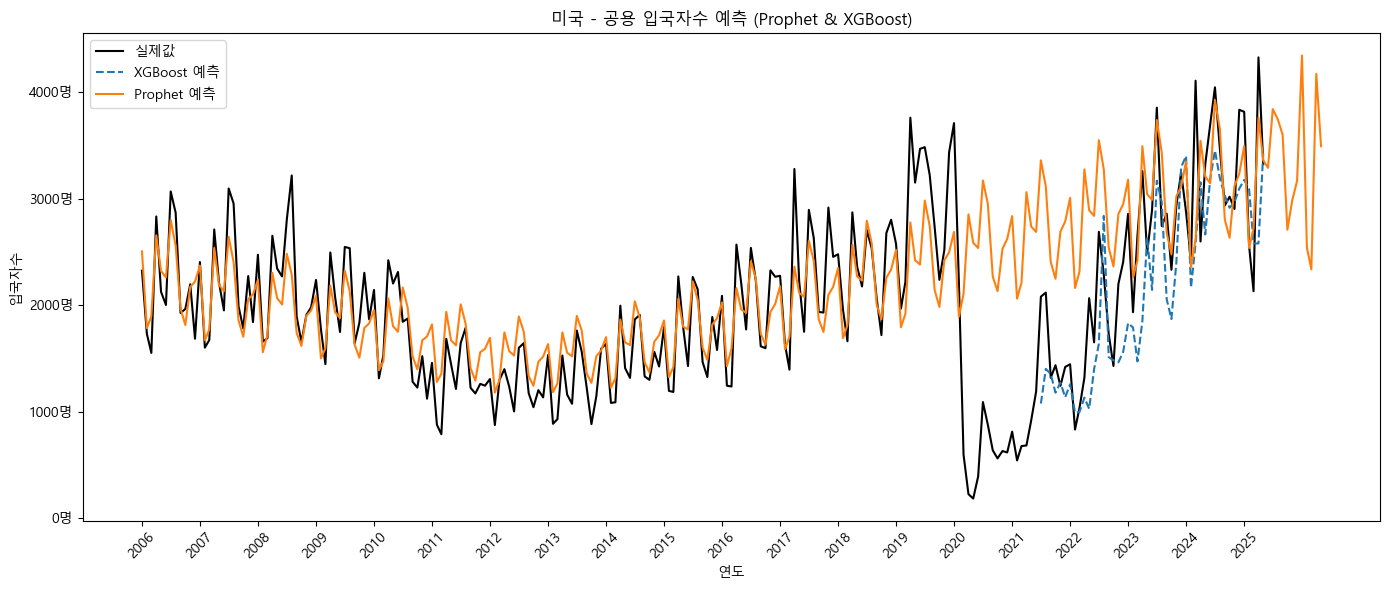

14:16:05 - cmdstanpy - INFO - Chain [1] start processing
14:16:05 - cmdstanpy - INFO - Chain [1] done processing


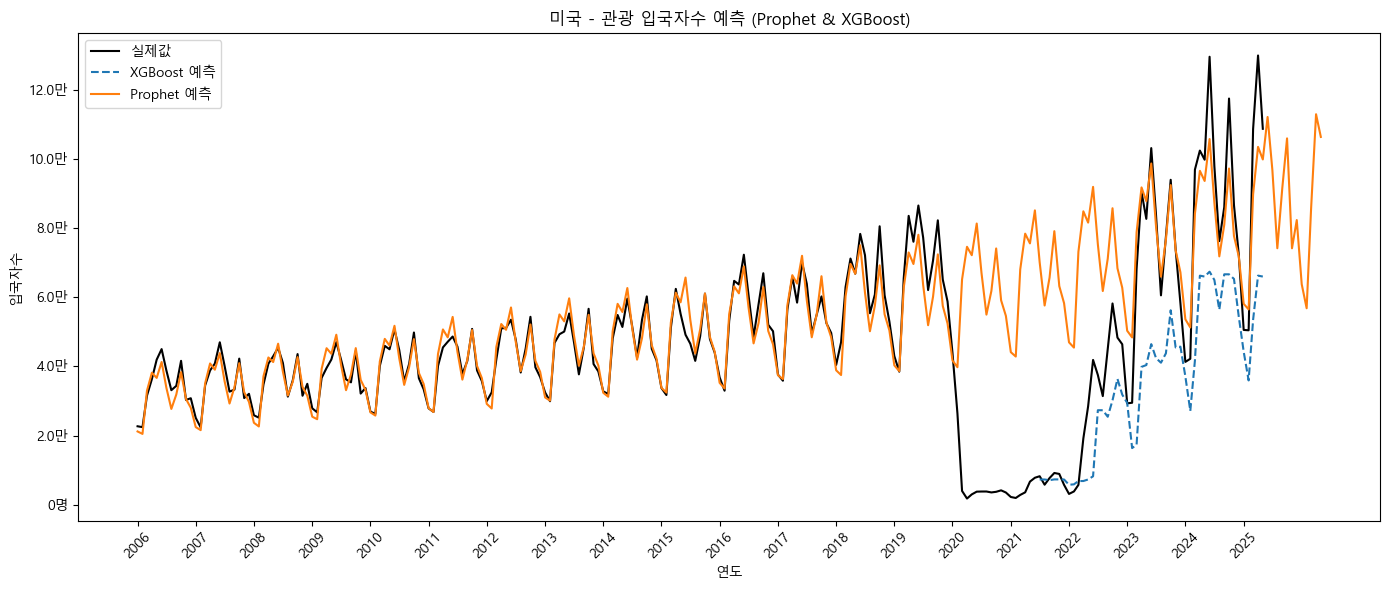

14:16:05 - cmdstanpy - INFO - Chain [1] start processing
14:16:05 - cmdstanpy - INFO - Chain [1] done processing


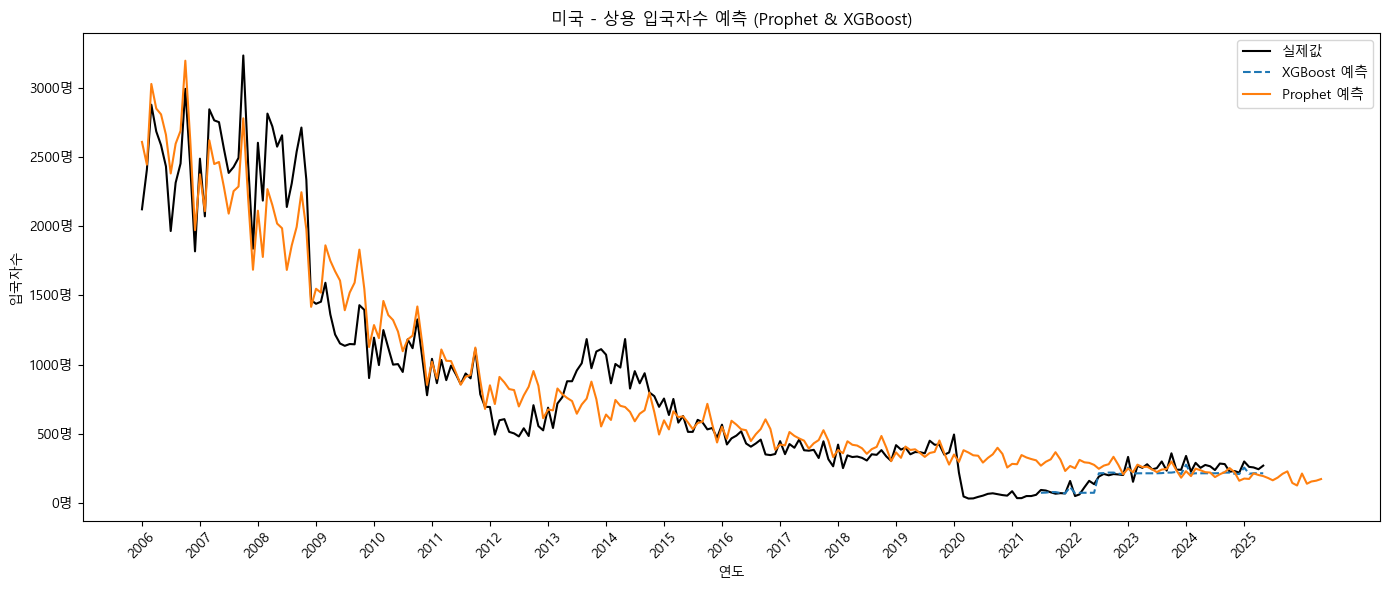

14:16:06 - cmdstanpy - INFO - Chain [1] start processing
14:16:06 - cmdstanpy - INFO - Chain [1] done processing


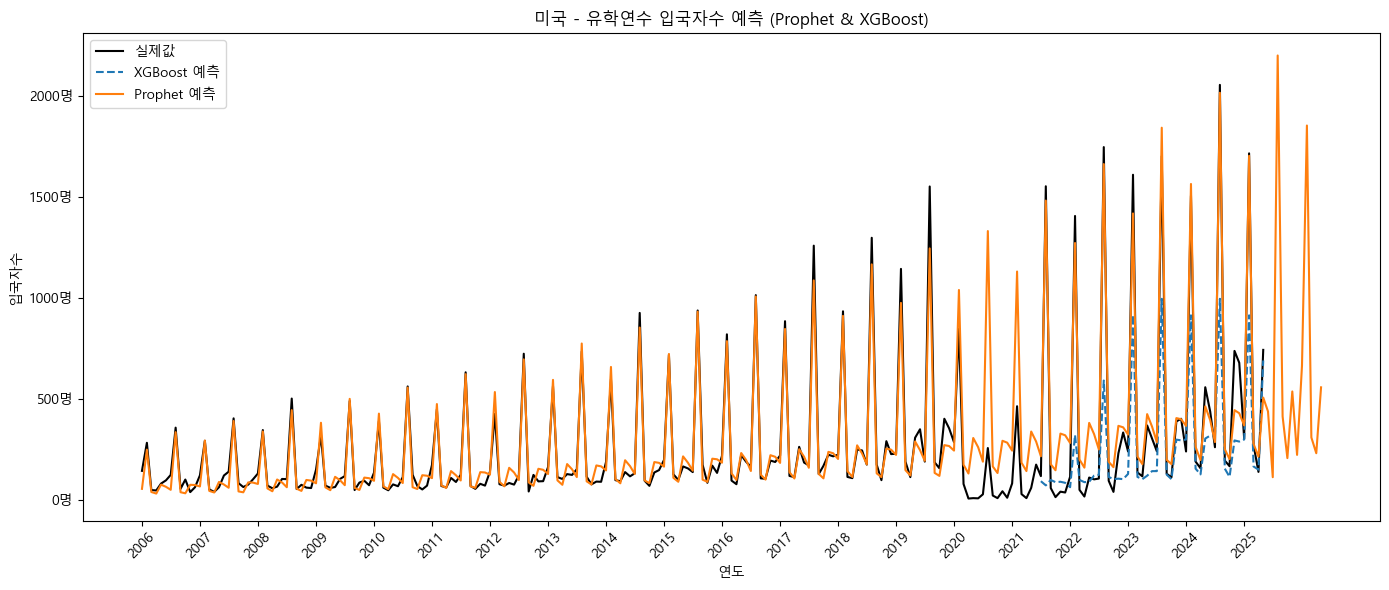

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ‚úÖ ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('../../jin/data/processed/Ïô∏Íµ≠Ïù∏ÏûÖÍµ≠Ïûê_Ï†ÑÏ≤òÎ¶¨ÏôÑÎ£å_Îî•Îü¨ÎãùÏö©.csv', encoding='utf-8')

# ‚úÖ ÏÇ¨Ïö©Ïûê ÏûÖÎ†• Ìï®Ïàò
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"‚ùå ÏùºÏπòÌïòÎäî {column_name} ÏóÜÏùå. Îã§Ïãú ÏûÖÎ†•.")

# ‚úÖ Íµ≠Í∞Ä & Î™©Ï†Å ÏûÖÎ†•
country = get_valid_input('Íµ≠Ï†Å')
purpose_input = get_valid_input('Î™©Ï†Å', allow_blank=True)

# ‚úÖ Íµ≠Í∞ÄÎ°ú ÌïÑÌÑ∞
df = df[df['Íµ≠Ï†Å'] == country]

# ‚úÖ Î™©Ï†Å Î£®ÌîÑ ÎåÄÏÉÅ
purpose_list = [purpose_input] if purpose_input else df['Î™©Ï†Å'].unique()

# ‚úÖ Í≥µÌÜµ Label Encoding
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['Í≥ÑÏ†à'] = le_season.fit_transform(df['Í≥ÑÏ†à'])
df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = le_corona.fit_transform(df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'])
df['Ïó∞Ïõî'] = df['Ïó∞ÎèÑ'].astype(str) + '-' + df['Ïõî'].astype(str).str.zfill(2)

# ‚úÖ ÌäπÏù¥Ï†ê Dummy + Ïä§ÏºÄÏùºÏóÖ
df['ÏÑ±ÏàòÍ∏∞'] = df['Ïõî'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
df['Î™ÖÏ†à'] = df['Ïõî'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

# ‚úÖ YÏ∂ï Formatter
def to_unit(x, pos):
    if x >= 10000:
        return f'{x/10000:.1f}Îßå'
    else:
        return f'{int(x)}Î™Ö'

# ‚úÖ Î™©Ï†ÅÎ≥Ñ Î£®ÌîÑ
for purpose in purpose_list:
    temp_df = df[df['Î™©Ï†Å'] == purpose] if purpose_input else df[df['Î™©Ï†Å'] == purpose]
    if temp_df.empty:
        print(f"‚ö†Ô∏è Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå: {purpose}")
        continue

    # ‚úÖ Feature Engineering
    temp_df = temp_df.copy()
    temp_df['lag_1'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(1)
    temp_df['lag_3'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(3)
    temp_df['lag_12'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(12)
    temp_df['ÏûÖÍµ≠ÏûêÏàò_cumsum'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].cumsum()
    temp_df = temp_df.dropna()

    features = [
        'Ïó∞ÎèÑ', 'Ïõî', 'Î∂ÑÍ∏∞', 'Í≥ÑÏ†à', 'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ', 'ÏÑ±ÏàòÍ∏∞', 'Î™ÖÏ†à',
        'lag_1', 'lag_3', 'lag_12', 'ÏûÖÍµ≠ÏûêÏàò_cumsum'
    ]
    X = temp_df[features]
    y = temp_df['ÏûÖÍµ≠ÏûêÏàò']
    ym = temp_df['Ïó∞Ïõî'].reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
        X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
    )

    params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
    grid = GridSearchCV(XGBRegressor(), params, cv=2)
    grid.fit(X_train, y_train)
    xgb_model = grid.best_estimator_

    y_pred = xgb_model.predict(X_test)
    results = pd.DataFrame({
        'Ïã§Ï†úÍ∞í': y_test.values,
        'ÏòàÏ∏°Í∞í': y_pred,
        'Ïó∞Ïõî': ym_test.values
    })
    results['date'] = pd.to_datetime(results['Ïó∞Ïõî'])
    temp_df['date'] = pd.to_datetime(temp_df['Ïó∞Ïõî'])

    # ‚úÖ Prophet
    prophet_df = temp_df[['Ïó∞Ïõî', 'ÏûÖÍµ≠ÏûêÏàò', 'Ïõî', 'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ', 'ÏÑ±ÏàòÍ∏∞', 'Î™ÖÏ†à']].copy()
    prophet_df.rename(columns={'Ïó∞Ïõî': 'ds', 'ÏûÖÍµ≠ÏûêÏàò': 'y'}, inplace=True)
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    m.add_regressor('ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ')
    m.add_regressor('ÏÑ±ÏàòÍ∏∞')
    m.add_regressor('Î™ÖÏ†à')
    m.fit(prophet_df)

    future = m.make_future_dataframe(periods=12, freq='M')
    future['Ïõî'] = future['ds'].dt.month
    future['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = 0
    future['ÏÑ±ÏàòÍ∏∞'] = future['Ïõî'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
    future['Î™ÖÏ†à'] = future['Ïõî'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

    forecast = m.predict(future)

    # ‚úÖ ÎπÑÍµê Í∑∏ÎûòÌîÑ Ï∂úÎ†•
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(temp_df['date'], temp_df['ÏûÖÍµ≠ÏûêÏàò'], label='Ïã§Ï†úÍ∞í', color='black')
    ax.plot(results['date'], results['ÏòàÏ∏°Í∞í'], linestyle='--', label='XGBoost ÏòàÏ∏°')
    ax.plot(forecast['ds'], forecast['yhat'], linestyle='-', label='Prophet ÏòàÏ∏°')

    year_ticks = temp_df[temp_df['date'].dt.month == 1]['date'].drop_duplicates()
    ax.set_xticks(year_ticks)
    ax.set_xticklabels([d.strftime('%Y') for d in year_ticks], rotation=45)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))

    ax.set_title(f"{country} - {purpose} ÏûÖÍµ≠ÏûêÏàò ÏòàÏ∏° (Prophet & XGBoost)")
    ax.set_xlabel('Ïó∞ÎèÑ')
    ax.set_ylabel('ÏûÖÍµ≠ÏûêÏàò')
    ax.legend()
    plt.tight_layout()
    plt.show()


Importing plotly failed. Interactive plots will not work.


Íµ≠Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): Ï§ëÍµ≠
Î™©Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ÏÉÅÏö©


15:55:19 - cmdstanpy - INFO - Chain [1] start processing
15:55:19 - cmdstanpy - INFO - Chain [1] done processing


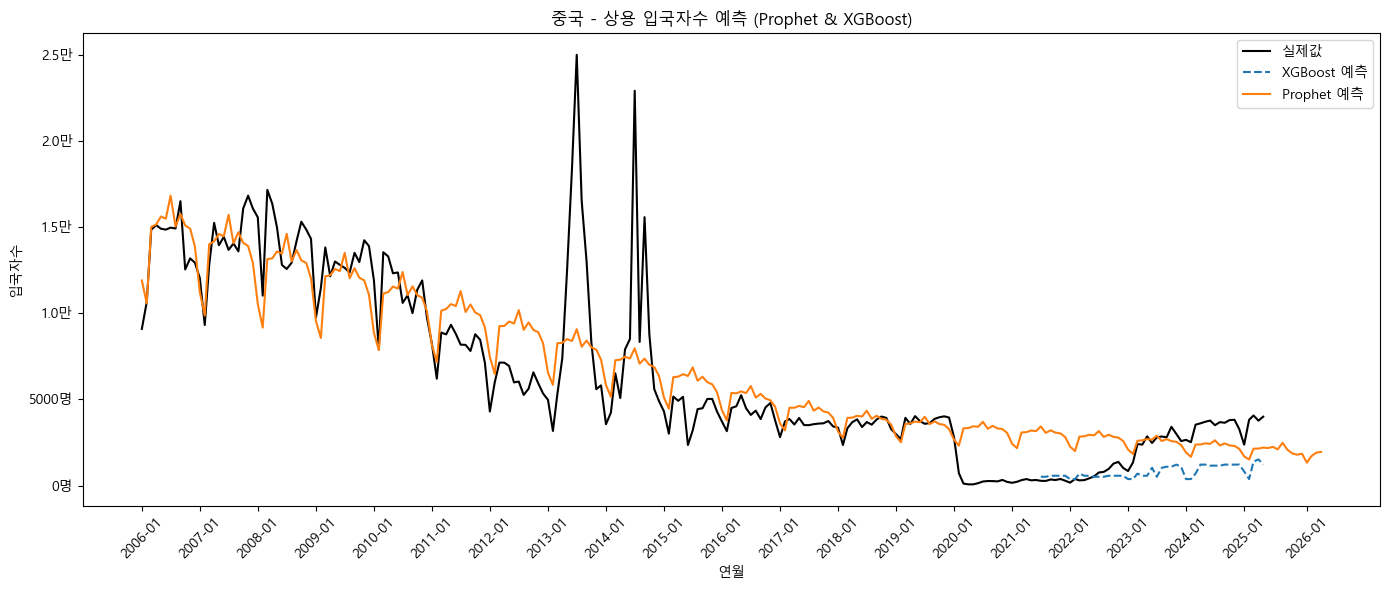

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ‚úÖ ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('../../jin/data/processed/Ïô∏Íµ≠Ïù∏ÏûÖÍµ≠Ïûê_Ï†ÑÏ≤òÎ¶¨ÏôÑÎ£å_Îî•Îü¨ÎãùÏö©.csv', encoding='utf-8')

# ‚úÖ ÏÇ¨Ïö©Ïûê ÏûÖÎ†• Ìï®Ïàò
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"‚ùå ÏùºÏπòÌïòÎäî {column_name} ÏóÜÏùå. Îã§Ïãú ÏûÖÎ†•.")

# ‚úÖ Íµ≠Í∞Ä & Î™©Ï†Å ÏûÖÎ†•
country = get_valid_input('Íµ≠Ï†Å')
purpose_input = get_valid_input('Î™©Ï†Å', allow_blank=True)

# ‚úÖ Íµ≠Í∞ÄÎ°ú ÌïÑÌÑ∞
df = df[df['Íµ≠Ï†Å'] == country]

# ‚úÖ Î™©Ï†Å Î£®ÌîÑ ÎåÄÏÉÅ
purpose_list = [purpose_input] if purpose_input else df['Î™©Ï†Å'].unique()

# ‚úÖ Í≥µÌÜµ Label Encoding
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['Í≥ÑÏ†à'] = le_season.fit_transform(df['Í≥ÑÏ†à'])
df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = le_corona.fit_transform(df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'])
df['Ïó∞Ïõî'] = df['Ïó∞ÎèÑ'].astype(str) + '-' + df['Ïõî'].astype(str).str.zfill(2)

# ‚úÖ ÌäπÏù¥Ï†ê Dummy + Ïä§ÏºÄÏùºÏóÖ
df['ÏÑ±ÏàòÍ∏∞'] = df['Ïõî'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
df['Î™ÖÏ†à'] = df['Ïõî'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

# ‚úÖ YÏ∂ï Formatter
def to_unit(x, pos):
    if x >= 10000:
        return f'{x/10000:.1f}Îßå'
    else:
        return f'{int(x)}Î™Ö'

# ‚úÖ Î™©Ï†ÅÎ≥Ñ Î£®ÌîÑ
for purpose in purpose_list:
    temp_df = df[df['Î™©Ï†Å'] == purpose] if purpose_input else df[df['Î™©Ï†Å'] == purpose]
    if temp_df.empty:
        print(f"‚ö†Ô∏è Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå: {purpose}")
        continue

    # ‚úÖ Feature Engineering
    temp_df = temp_df.copy()
    temp_df['lag_1'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(1)
    temp_df['lag_3'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(3)
    temp_df['lag_12'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(12)
    temp_df['ÏûÖÍµ≠ÏûêÏàò_cumsum'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].cumsum()
    temp_df = temp_df.dropna()

    features = [
        'Ïó∞ÎèÑ', 'Ïõî', 'Î∂ÑÍ∏∞', 'Í≥ÑÏ†à', 'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ', 'ÏÑ±ÏàòÍ∏∞', 'Î™ÖÏ†à',
        'lag_1', 'lag_3', 'lag_12', 'ÏûÖÍµ≠ÏûêÏàò_cumsum'
    ]
    X = temp_df[features]
    y = temp_df['ÏûÖÍµ≠ÏûêÏàò']
    ym = temp_df['Ïó∞Ïõî'].reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
        X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
    )

    params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
    grid = GridSearchCV(XGBRegressor(), params, cv=2)
    grid.fit(X_train, y_train)
    xgb_model = grid.best_estimator_

    y_pred = xgb_model.predict(X_test)
    results = pd.DataFrame({
        'Ïã§Ï†úÍ∞í': y_test.values,
        'ÏòàÏ∏°Í∞í': y_pred,
        'Ïó∞Ïõî': ym_test.values
    })
    results['date'] = pd.to_datetime(results['Ïó∞Ïõî'])
    temp_df['date'] = pd.to_datetime(temp_df['Ïó∞Ïõî'])

    # ‚úÖ Prophet
    prophet_df = temp_df[['Ïó∞Ïõî', 'ÏûÖÍµ≠ÏûêÏàò', 'Ïõî', 'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ', 'ÏÑ±ÏàòÍ∏∞', 'Î™ÖÏ†à']].copy()
    prophet_df.rename(columns={'Ïó∞Ïõî': 'ds', 'ÏûÖÍµ≠ÏûêÏàò': 'y'}, inplace=True)
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    m.add_regressor('ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ')
    m.add_regressor('ÏÑ±ÏàòÍ∏∞')
    m.add_regressor('Î™ÖÏ†à')
    m.fit(prophet_df)

    future = m.make_future_dataframe(periods=12, freq='M')
    future['Ïõî'] = future['ds'].dt.month
    future['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = 0
    future['ÏÑ±ÏàòÍ∏∞'] = future['Ïõî'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
    future['Î™ÖÏ†à'] = future['Ïõî'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

    forecast = m.predict(future)
    forecast['date'] = forecast['ds']

    # ‚úÖ ‚úÖ ‚úÖ Í≥ºÍ±∞ + ÎØ∏Îûò Ïó∞Ïõî Tick ÌÜµÌï©
    all_dates = pd.concat([temp_df['date'], forecast['date']]).drop_duplicates().sort_values()
    year_ticks = all_dates[all_dates.dt.month == 1]
    
    # ‚úÖ ÎπÑÍµê Í∑∏ÎûòÌîÑ Ï∂úÎ†•
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(temp_df['date'], temp_df['ÏûÖÍµ≠ÏûêÏàò'], label='Ïã§Ï†úÍ∞í', color='black')
    ax.plot(results['date'], results['ÏòàÏ∏°Í∞í'], linestyle='--', label='XGBoost ÏòàÏ∏°')
    ax.plot(forecast['date'], forecast['yhat'], linestyle='-', label='Prophet ÏòàÏ∏°')

    ax.set_xticks(year_ticks)
    ax.set_xticklabels([d.strftime('%Y-%m') for d in year_ticks], rotation=45)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))

    ax.set_title(f"{country} - {purpose} ÏûÖÍµ≠ÏûêÏàò ÏòàÏ∏° (Prophet & XGBoost)")
    ax.set_xlabel('Ïó∞Ïõî')
    ax.set_ylabel('ÏûÖÍµ≠ÏûêÏàò')
    ax.legend()
    plt.tight_layout()
    plt.show()


Íµ≠Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): Ï§ëÍµ≠
Î™©Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): 
‚úÖ Í≥µÏö© - XGBoost MAE: 49.61, RMSE: 72.95


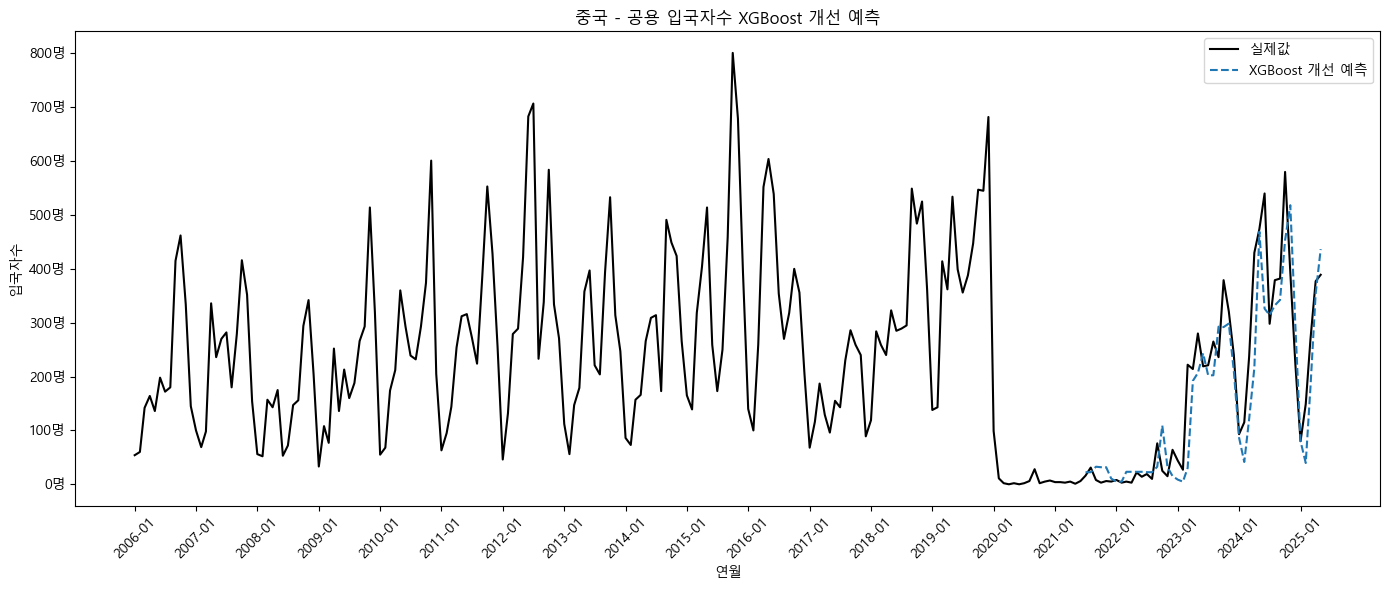

‚úÖ Í¥ÄÍ¥ë - XGBoost MAE: 59110.36, RMSE: 87196.55


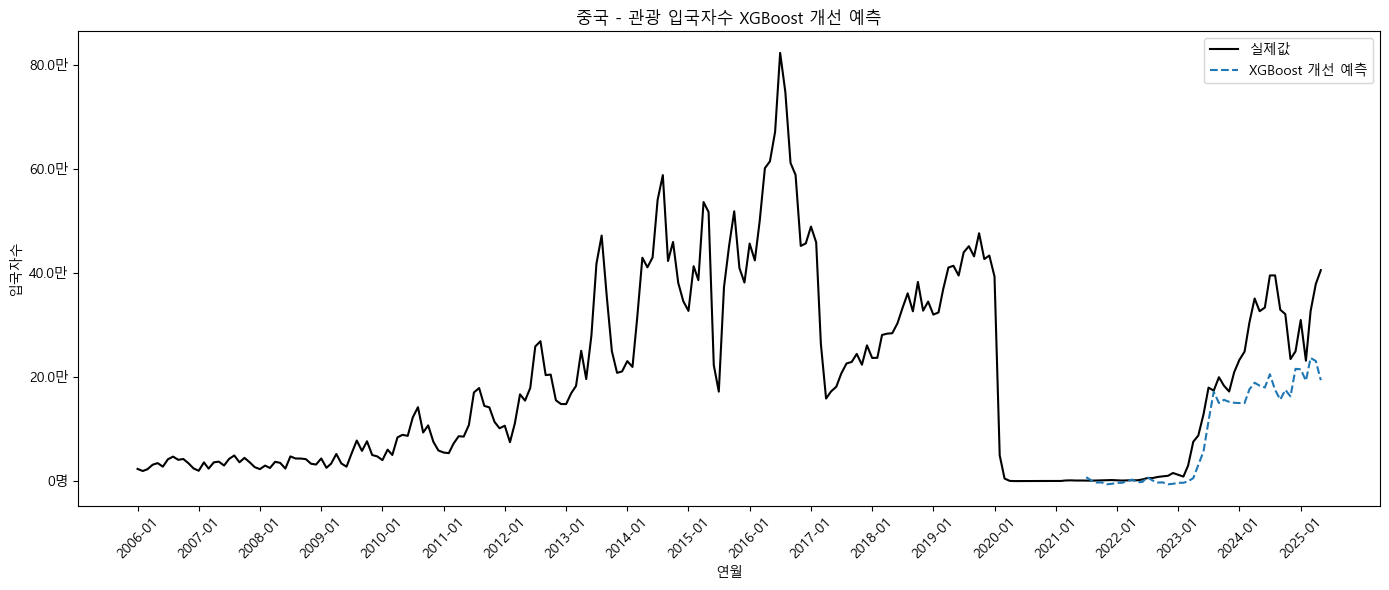

‚úÖ ÏÉÅÏö© - XGBoost MAE: 1448.54, RMSE: 1782.20


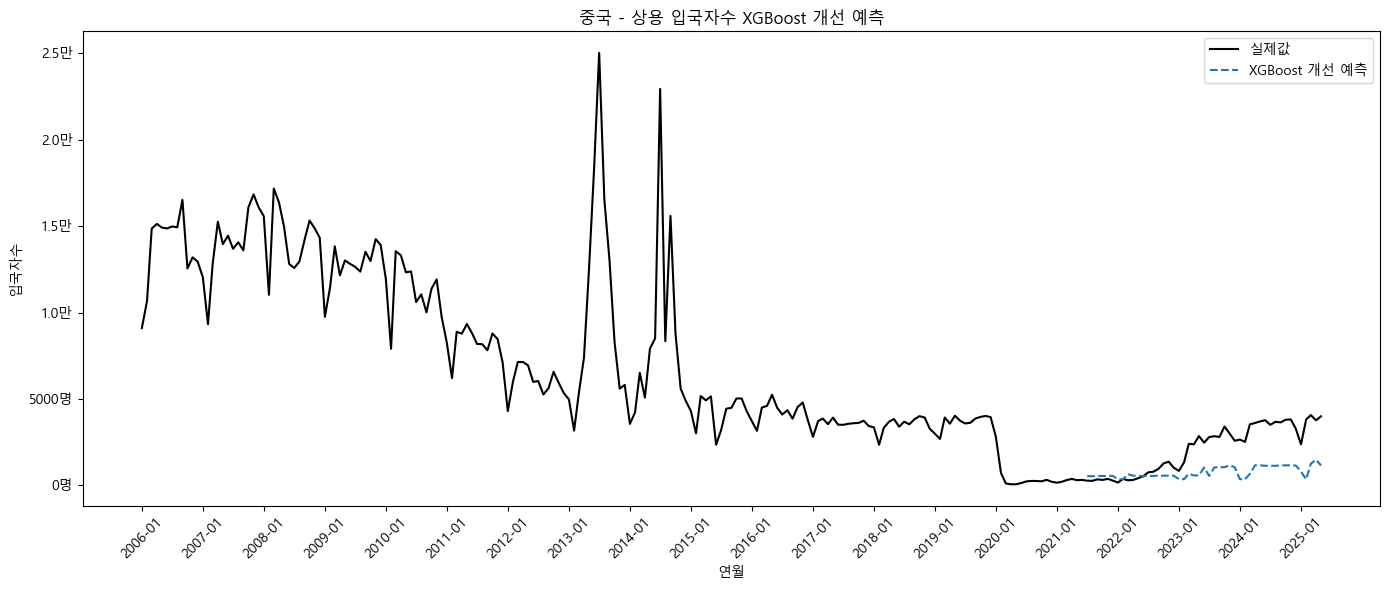

‚úÖ Ïú†ÌïôÏó∞Ïàò - XGBoost MAE: 4778.21, RMSE: 7776.25


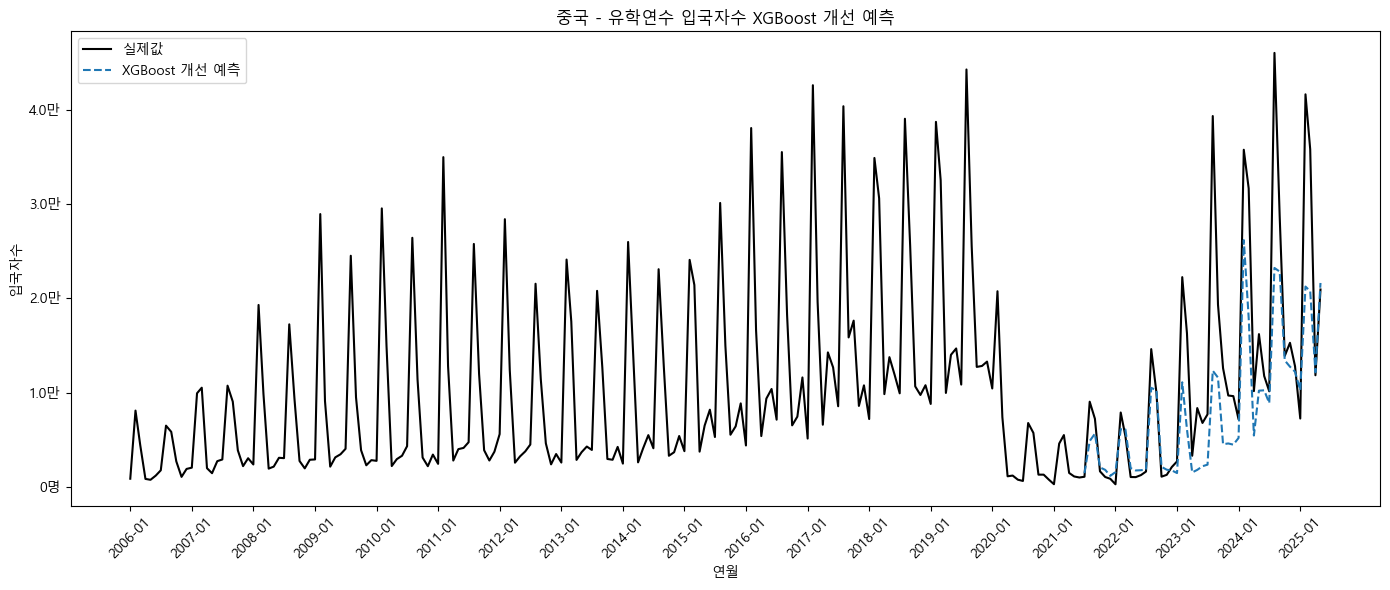

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ‚úÖ ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('../../jin/data/processed/Ïô∏Íµ≠Ïù∏ÏûÖÍµ≠Ïûê_Ï†ÑÏ≤òÎ¶¨ÏôÑÎ£å_Îî•Îü¨ÎãùÏö©.csv', encoding='utf-8')

# ‚úÖ ÏÇ¨Ïö©Ïûê ÏûÖÎ†• Ìï®Ïàò
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"‚ùå ÏùºÏπòÌïòÎäî {column_name} ÏóÜÏùå. Îã§Ïãú ÏûÖÎ†•.")

# ‚úÖ Íµ≠Í∞Ä & Î™©Ï†Å ÏûÖÎ†•
country = get_valid_input('Íµ≠Ï†Å')
purpose_input = get_valid_input('Î™©Ï†Å', allow_blank=True)

# ‚úÖ Íµ≠Í∞Ä ÌïÑÌÑ∞
df = df[df['Íµ≠Ï†Å'] == country]
purpose_list = [purpose_input] if purpose_input else df['Î™©Ï†Å'].unique()

# ‚úÖ Label Encoding
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['Í≥ÑÏ†à'] = le_season.fit_transform(df['Í≥ÑÏ†à'])
df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = le_corona.fit_transform(df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'])
df['Ïó∞Ïõî'] = df['Ïó∞ÎèÑ'].astype(str) + '-' + df['Ïõî'].astype(str).str.zfill(2)

# ‚úÖ ÌäπÏù¥Ï†ê Dummy + Ïä§ÏºÄÏùºÏóÖ
df['ÏÑ±ÏàòÍ∏∞'] = df['Ïõî'].apply(lambda x: 1 if x in [7,8,12] else 0) * 1.5
df['Î™ÖÏ†à'] = df['Ïõî'].apply(lambda x: 1 if x in [1,2,9,10] else 0) * 2.0
df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ_scaled'] = df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] * 5.0  # Ï∂©Í≤© Îçî Í∞ïÌïòÍ≤å

# ‚úÖ YÏ∂ï Formatter
def to_unit(x, pos):
    if x >= 10000:
        return f'{x/10000:.1f}Îßå'
    else:
        return f'{int(x)}Î™Ö'

for purpose in purpose_list:
    temp_df = df[df['Î™©Ï†Å'] == purpose] if purpose_input else df[df['Î™©Ï†Å'] == purpose]
    if temp_df.empty:
        print(f"‚ö†Ô∏è Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå: {purpose}")
        continue

    temp_df = temp_df.copy()

    # ‚úÖ Lag + Ïù¥ÎèôÌèâÍ∑†
    temp_df['lag_1'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(1)
    temp_df['lag_3'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(3)
    temp_df['lag_12'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(12)
    temp_df['rolling_3'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(1).rolling(3).mean()
    temp_df['rolling_12'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(1).rolling(12).mean()
    temp_df['ÏûÖÍµ≠ÏûêÏàò_cumsum'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].cumsum()
    temp_df = temp_df.dropna()

    features = [
        'Ïó∞ÎèÑ', 'Ïõî', 'Î∂ÑÍ∏∞', 'Í≥ÑÏ†à',
        'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ_scaled', 'ÏÑ±ÏàòÍ∏∞', 'Î™ÖÏ†à',
        'lag_1', 'lag_3', 'lag_12',
        'rolling_3', 'rolling_12',
        'ÏûÖÍµ≠ÏûêÏàò_cumsum'
    ]

    X = temp_df[features]
    y = temp_df['ÏûÖÍµ≠ÏûêÏàò']
    ym = temp_df['Ïó∞Ïõî'].reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
        X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
    )

    params = {'n_estimators': [100, 200], 'learning_rate': [0.05], 'max_depth': [3, 5]}
    grid = GridSearchCV(XGBRegressor(), params, cv=2)
    grid.fit(X_train, y_train)
    xgb_model = grid.best_estimator_

    y_pred = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f"‚úÖ {purpose} - XGBoost MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    results = pd.DataFrame({
        'Ïã§Ï†úÍ∞í': y_test.values,
        'ÏòàÏ∏°Í∞í': y_pred,
        'Ïó∞Ïõî': ym_test.values
    })
    results['date'] = pd.to_datetime(results['Ïó∞Ïõî'])
    temp_df['date'] = pd.to_datetime(temp_df['Ïó∞Ïõî'])

    # ‚úÖ XÏ∂ï Tick: Ïó∞Ïõî
    all_dates = pd.concat([temp_df['date'], results['date']]).drop_duplicates().sort_values()
    year_ticks = all_dates[all_dates.dt.month == 1]

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(temp_df['date'], temp_df['ÏûÖÍµ≠ÏûêÏàò'], label='Ïã§Ï†úÍ∞í', color='black')
    ax.plot(results['date'], results['ÏòàÏ∏°Í∞í'], linestyle='--', label='XGBoost Í∞úÏÑ† ÏòàÏ∏°')

    ax.set_xticks(year_ticks)
    ax.set_xticklabels([d.strftime('%Y-%m') for d in year_ticks], rotation=45)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))

    ax.set_title(f"{country} - {purpose} ÏûÖÍµ≠ÏûêÏàò XGBoost Í∞úÏÑ† ÏòàÏ∏°")
    ax.set_xlabel('Ïó∞Ïõî')
    ax.set_ylabel('ÏûÖÍµ≠ÏûêÏàò')
    ax.legend()
    plt.tight_layout()
    plt.show()


Íµ≠Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ÎØ∏Íµ≠
Î™©Ï†Å ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 186, number of used features: 13
[LightGBM] [Info] Start training from score 1825.580645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 13
[LightGBM] [Info] Start training from score 1730.824324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the 

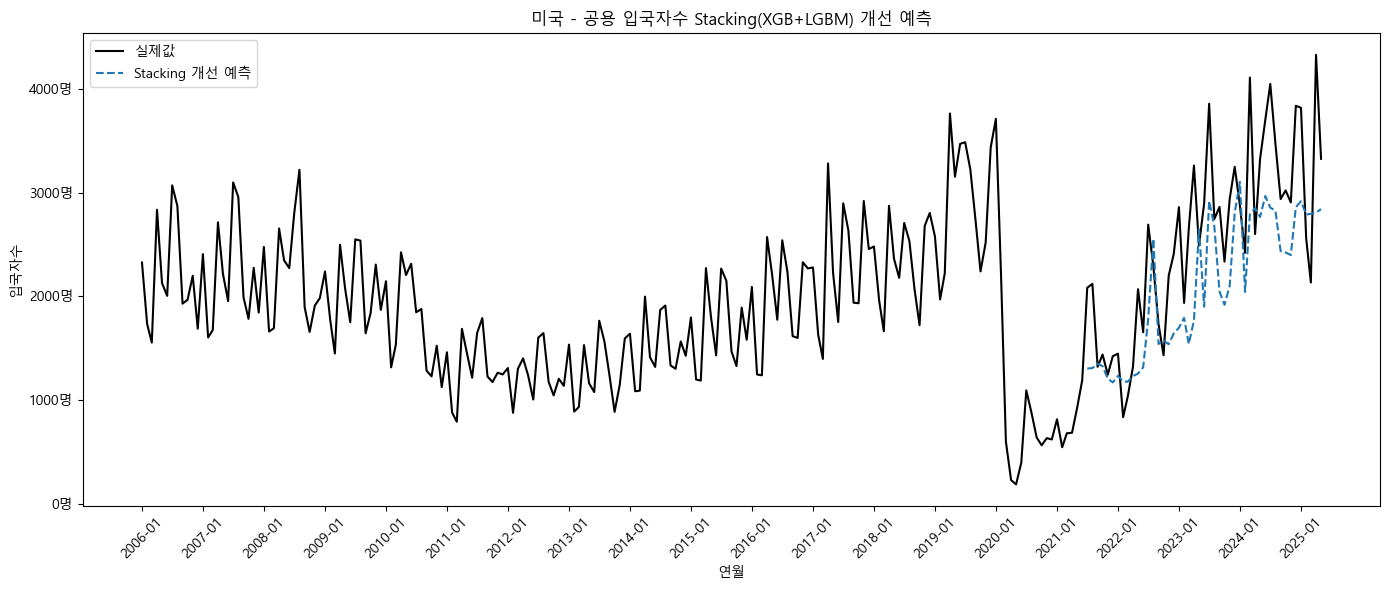

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 186, number of used features: 13
[LightGBM] [Info] Start training from score 42313.731183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 13
[LightGBM] [Info] Start training from score 44281.513514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 149, number of used features: 13
[LightGBM] [Info] Start trai

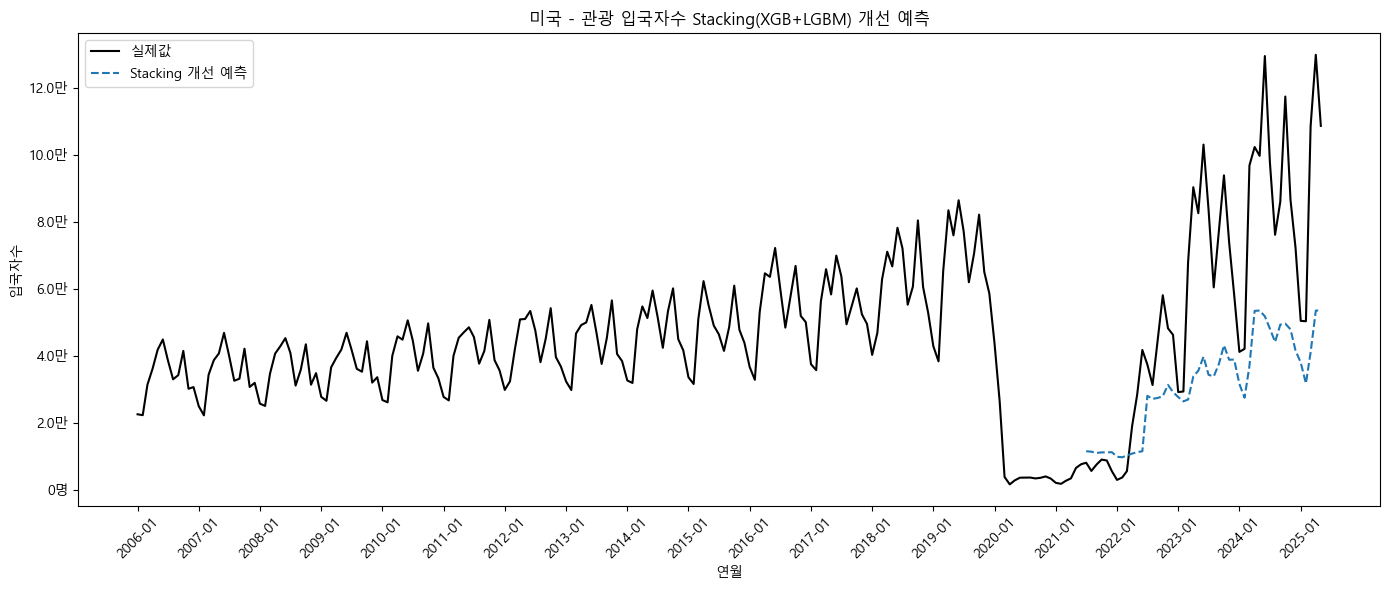

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 186, number of used features: 13
[LightGBM] [Info] Start training from score 986.580645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 13
[LightGBM] [Info] Start training from score 622.520270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 149, number of used features: 13
[LightGBM] [Info] Start training

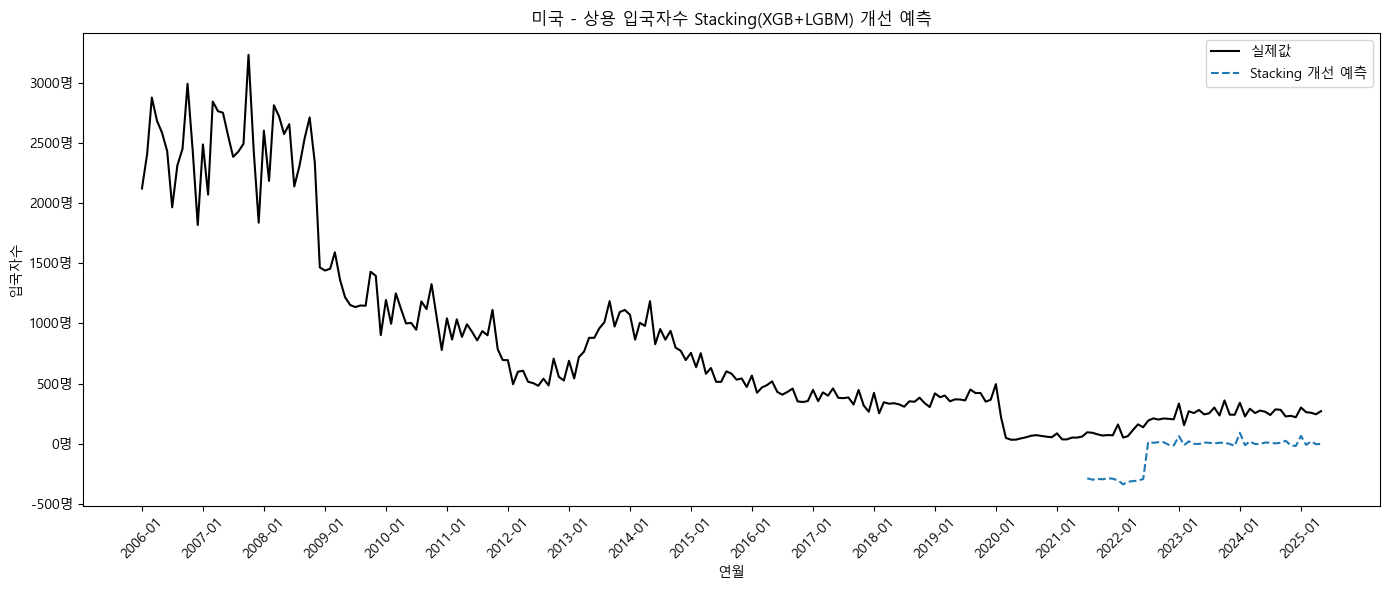

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 186, number of used features: 13
[LightGBM] [Info] Start training from score 212.505376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 13
[LightGBM] [Info] Start training from score 232.601351
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 149, number of used features: 13
[LightGBM] [Info] Start training

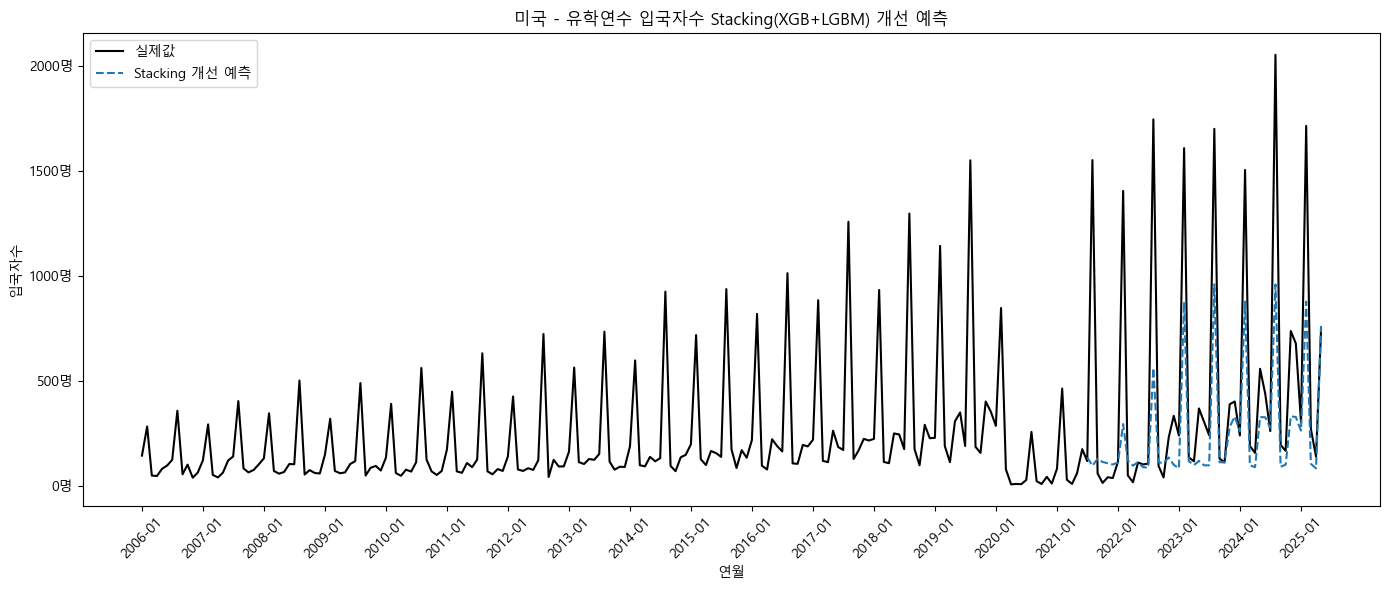

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ‚úÖ ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('../../jin/data/processed/Ïô∏Íµ≠Ïù∏ÏûÖÍµ≠Ïûê_Ï†ÑÏ≤òÎ¶¨ÏôÑÎ£å_Îî•Îü¨ÎãùÏö©.csv', encoding='utf-8')

def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} ÏûÖÎ†• (ÏóÜÏúºÎ©¥ Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"‚ùå ÏùºÏπòÌïòÎäî {column_name} ÏóÜÏùå. Îã§Ïãú ÏûÖÎ†•.")

country = get_valid_input('Íµ≠Ï†Å')
purpose_input = get_valid_input('Î™©Ï†Å', allow_blank=True)

df = df[df['Íµ≠Ï†Å'] == country]
purpose_list = [purpose_input] if purpose_input else df['Î™©Ï†Å'].unique()

le_season = LabelEncoder()
le_corona = LabelEncoder()
df['Í≥ÑÏ†à'] = le_season.fit_transform(df['Í≥ÑÏ†à'])
df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] = le_corona.fit_transform(df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'])
df['Ïó∞Ïõî'] = df['Ïó∞ÎèÑ'].astype(str) + '-' + df['Ïõî'].astype(str).str.zfill(2)

df['ÏÑ±ÏàòÍ∏∞'] = df['Ïõî'].apply(lambda x: 1 if x in [7,8,12] else 0) * 1.5
df['Î™ÖÏ†à'] = df['Ïõî'].apply(lambda x: 1 if x in [1,2,9,10] else 0) * 2.0
df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ_scaled'] = df['ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ'] * 5.0

def to_unit(x, pos):
    if x >= 10000:
        return f'{x/10000:.1f}Îßå'
    else:
        return f'{int(x)}Î™Ö'

for purpose in purpose_list:
    temp_df = df[df['Î™©Ï†Å'] == purpose] if purpose_input else df[df['Î™©Ï†Å'] == purpose]
    if temp_df.empty:
        print(f"‚ö†Ô∏è Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå: {purpose}")
        continue

    temp_df = temp_df.copy()

    temp_df['lag_1'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(1)
    temp_df['lag_3'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(3)
    temp_df['lag_12'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(12)
    temp_df['rolling_3'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(1).rolling(3).mean()
    temp_df['rolling_12'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].shift(1).rolling(12).mean()
    temp_df['ÏûÖÍµ≠ÏûêÏàò_cumsum'] = temp_df['ÏûÖÍµ≠ÏûêÏàò'].cumsum()
    temp_df = temp_df.dropna()

    features = [
        'Ïó∞ÎèÑ', 'Ïõî', 'Î∂ÑÍ∏∞', 'Í≥ÑÏ†à',
        'ÏΩîÎ°úÎÇòÍ∏∞Í∞Ñ_scaled', 'ÏÑ±ÏàòÍ∏∞', 'Î™ÖÏ†à',
        'lag_1', 'lag_3', 'lag_12',
        'rolling_3', 'rolling_12',
        'ÏûÖÍµ≠ÏûêÏàò_cumsum'
    ]

    X = temp_df[features]
    y = temp_df['ÏûÖÍµ≠ÏûêÏàò']
    ym = temp_df['Ïó∞Ïõî'].reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
        X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
    )

    # ‚úÖ LGBM clean ÌååÎùºÎØ∏ÌÑ∞
    lgbm = LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=None,
        min_child_samples=1,  # min_data_in_leaf ÎåÄÏã† ÏÇ¨Ïö©
        min_split_gain=0.00001,
        random_state=42
    )

    xgb = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )

    stacked = StackingRegressor(
        estimators=[('xgb', xgb), ('lgbm', lgbm)],
        final_estimator=Ridge()
    )

    stacked.fit(X_train, y_train)

    y_pred = stacked.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f"‚úÖ {purpose} - Stacking (XGB+LGBM) MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    results = pd.DataFrame({
        'Ïã§Ï†úÍ∞í': y_test.values,
        'ÏòàÏ∏°Í∞í': y_pred,
        'Ïó∞Ïõî': ym_test.values
    })
    results['date'] = pd.to_datetime(results['Ïó∞Ïõî'])
    temp_df['date'] = pd.to_datetime(temp_df['Ïó∞Ïõî'])

    all_dates = pd.concat([temp_df['date'], results['date']]).drop_duplicates().sort_values()
    year_ticks = all_dates[all_dates.dt.month == 1]

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(temp_df['date'], temp_df['ÏûÖÍµ≠ÏûêÏàò'], label='Ïã§Ï†úÍ∞í', color='black')
    ax.plot(results['date'], results['ÏòàÏ∏°Í∞í'], linestyle='--', label='Stacking Í∞úÏÑ† ÏòàÏ∏°')

    ax.set_xticks(year_ticks)
    ax.set_xticklabels([d.strftime('%Y-%m') for d in year_ticks], rotation=45)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))

    ax.set_title(f"{country} - {purpose} ÏûÖÍµ≠ÏûêÏàò Stacking(XGB+LGBM) Í∞úÏÑ† ÏòàÏ∏°")
    ax.set_xlabel('Ïó∞Ïõî')
    ax.set_ylabel('ÏûÖÍµ≠ÏûêÏàò')
    ax.legend()
    plt.tight_layout()
    plt.show()
